In [1]:
!/opt/bin/nvidia-smi

Fri Mar  4 12:02:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! ls "/content/drive/My Drive/nlp-beginner"

acc1.png  loss1.png		test_input2.npy  train_input2.npy
data	  task2-RNN-else.ipynb	test_input3.npy  train_input3.npy
img	  task2-RNN.ipynb	test_input.npy	 train_input.npy


In [8]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import time
import torchtext.vocab as Vocab
import os
from sklearn.model_selection import train_test_split

""" 设置随机种子 """
torch.manual_seed(33)
torch.cuda.manual_seed(33)
np.random.seed(33)

In [9]:
import re
import collections
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchtext.vocab import vocab
from collections import OrderedDict
import pandas as pd
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')


def save_img(loss, acc, test_acc):
    num_epochs = len(loss)
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, test_acc, 'r', label='validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc='lower right')
    plt.figure()
    plt.savefig("/content/drive/My Drive/nlp-beginner/acc1.png")

    plt.plot(epochs, loss, 'r', label='Training loss')
    # plt.plot(epochs, val_loss, 'b', label='validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig("/content/drive/My Drive/nlp-beginner/loss1.png")


def load_pretrained_embedding(words, pretrained_vocab):
    """从预训练好的vocab中提取出words对应的词向量"""
    embed = torch.zeros(len(words), pretrained_vocab.vectors[0].shape[0]) # 初始化为0
    oov_count = 0 # out of vocabulary
    for i, word in enumerate(words):
        try:
            idx = pretrained_vocab.stoi[word]
            embed[i, :] = pretrained_vocab.vectors[idx]
        except KeyError:
            oov_count += 1
    if oov_count > 0:
        print("There are %d oov words." % oov_count)
    return embed


def load_data(data_path):
    data = pd.read_csv(data_path, sep="\t")
    print("data.shape: ", data.shape)  # (156060, 4)
    # 提取句子与标签的列
    x = data["Phrase"]
    y = data["Sentiment"]
    return x, torch.tensor(y)


# 预处理文本：全部转小写、去除标点符号
def pre_process(text):
    text = text.lower()  # 转小写
    # 去除标点符号
    punctuation = '!,;:?."\'、，；`'
    text = re.sub(r'[{}]+'.format(punctuation), ' ', text)
    return text.strip()


# 分词
def get_tokenized_sent(sents):
    stopWords = set(stopwords.words('english'))
    def tokenizer(text):
        words = word_tokenize(text)
        words = [word.lower() for word in words
                 if word.isalpha() and word not in stopWords]
        return words
    return [tokenizer(review) for review in sents]


# 获得数据集的词典
def get_vocab(sents):
    tokenized_data = get_tokenized_sent(sents)
    counter = collections.Counter([tk for st in tokenized_data for tk in st])
    sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    min_feq = 3
    idx = len(sorted_by_freq_tuples) - 1
    while sorted_by_freq_tuples[idx][1] < min_feq:
        sorted_by_freq_tuples.pop(idx)
        idx -= 1
    # 用<NOF>表示未找到的词
    sorted_by_freq_tuples.append(('<NOF>', 1))
    ordered_dict = OrderedDict(sorted_by_freq_tuples)
    vocab_obj = vocab(ordered_dict)
    return vocab_obj


def words2id(vocab_dic, words):
    def pad(x):
        return x[:MAX_LEN] if len(x) > MAX_LEN else x + [0] * (MAX_LEN - len(x))

    vec = []
    not_found_id = len(vocab_dic) - 1
    for word in words:
        try:
            vec.append(vocab_dic[word])
        except KeyError:
            vec.append(not_found_id)
    return pad(vec)


# 将句子转成长度一致的 词序号向量
def preprocess_data(sents, vocab_dic, file_name):
    tokenized_data = get_tokenized_sent(sents)
    list = []
    for words in tqdm(tokenized_data):
        list.append(words2id(vocab_dic, words))
    # np.save(file_name, np.array(list))
    return torch.tensor(np.array(list))


def get_sents_ids(file_path):
    sents_ids = np.load(file_path).tolist()
    return torch.tensor(sents_ids)


def analysis_len(sents):
    sents_len = [len(sent) for sent in sents]
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.figure(figsize=(30, 12), dpi=100)
    plt.subplot(2, 3, 2)
    plt.title("句子长度分布")
    plt.hist(sents_len, bins=list(range(0, max(sents_len) + 1, 1)))
    plt.xlabel('句子长度')
    plt.ylabel('句子数量')
    """ title 累计分布"""
    plt.subplot(2, 3, 5)
    plt.title('累计分布图')
    plt.hist(sents_len, bins=list(range(0, max(sents_len) + 1, 1)), cumulative=True)
    plt.xlabel('句子长度')
    plt.ylabel('累计比例(%)')
    plt.savefig("sent_len.png")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_layers, num_outputs):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(len(vocab), embed_size)
        # bidirectional设为True即得到双向循环神经网络
        self.encoder = nn.LSTM(input_size=embed_size,
                                hidden_size=num_hiddens,
                                num_layers=num_layers,
                                bidirectional=True)
        # 初始时间步和最终时间步的隐藏状态作为全连接层输入
        # self.dropout = nn.Dropout(0.6)
        self.decoder = nn.Linear(4*num_hiddens, num_outputs)

    def forward(self, inputs):
        # inputs的形状是(批量大小, 词数)，因为LSTM需要将序列长度(seq_len)作为第一维，所以将输入转置后
        # 再提取词特征，输出形状为(词数, 批量大小, 词向量维度)
        embeddings = self.embedding(inputs.permute(1, 0))
        # rnn.LSTM只传入输入embeddings，因此只返回最后一层的隐藏层在各时间步的隐藏状态。
        # outputs形状是(词数, 批量大小, 2 * 隐藏单元个数)
        outputs, (h, C) = self.encoder(embeddings) # output, (h, c)
        # 连结初始时间步和最终时间步的隐藏状态作为全连接层输入。它的形状为
        # (批量大小, 4 * 隐藏单元个数)。
        encoding = torch.cat((outputs[0], outputs[-1]), -1)
        # encoding = torch.cat((h[-1], h[-2]), -1)
        # encoding = self.dropout(encoding)
        outs = self.decoder(encoding)
        return outs

In [12]:
data_path = "/content/drive/My Drive/nlp-beginner"

embed_size = 100
num_hiddens = 100
num_layers = 1
lr = 0.005
num_epochs = 10
batch_size = 256
MAX_LEN = 30  # 将每条评论通过截断或者补0，使得长度变成500

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

DATA_ROOT = data_path + "/data"
glove_vocab = Vocab.GloVe(name='6B', dim=embed_size, cache=os.path.join(DATA_ROOT, "glove"))

In [15]:
train_path = data_path + "/data/train2.tsv"
# train_path = data_path + "/data/data.tsv"

test_path = data_path + "/data/test2.tsv"
train_sents, train_labels = load_data(train_path)
test_sents, test_labels = load_data(test_path)

# from data_process import analysis_len
# analysis_len([sent.split() for sent in train_sents])


x = pd.concat([train_sents, test_sents])
y = torch.cat((train_labels, test_labels), -1)
train_sents, test_sents, train_labels, test_labels = train_test_split(x, y, test_size=0.2)


data.shape:  (126874, 4)
data.shape:  (29186, 4)


# words in vocab: 14533


100%|██████████| 31212/31212 [00:00<00:00, 260307.12it/s]


training on  cuda:0


100%|██████████| 488/488 [00:09<00:00, 50.12it/s]


epoch 1, train loss 1.0327, train acc 0.587, test acc 0.628, time 10.4 sec


100%|██████████| 488/488 [00:09<00:00, 51.26it/s]


epoch 2, train loss 0.4093, train acc 0.669, test acc 0.645, time 10.2 sec


100%|██████████| 488/488 [00:09<00:00, 50.42it/s]


epoch 3, train loss 0.2410, train acc 0.704, test acc 0.649, time 10.4 sec


100%|██████████| 488/488 [00:09<00:00, 50.47it/s]


epoch 4, train loss 0.1628, train acc 0.731, test acc 0.648, time 10.4 sec


100%|██████████| 488/488 [00:09<00:00, 50.85it/s]


epoch 5, train loss 0.1187, train acc 0.750, test acc 0.646, time 10.4 sec


100%|██████████| 488/488 [00:09<00:00, 51.03it/s]


epoch 6, train loss 0.0911, train acc 0.768, test acc 0.642, time 10.3 sec


100%|██████████| 488/488 [00:09<00:00, 50.58it/s]


epoch 7, train loss 0.0726, train acc 0.781, test acc 0.640, time 10.3 sec


100%|██████████| 488/488 [00:09<00:00, 50.70it/s]


epoch 8, train loss 0.0598, train acc 0.791, test acc 0.630, time 10.3 sec


100%|██████████| 488/488 [00:09<00:00, 50.80it/s]


epoch 9, train loss 0.0507, train acc 0.797, test acc 0.633, time 10.3 sec


100%|██████████| 488/488 [00:09<00:00, 50.61it/s]


epoch 10, train loss 0.0437, train acc 0.803, test acc 0.633, time 10.4 sec


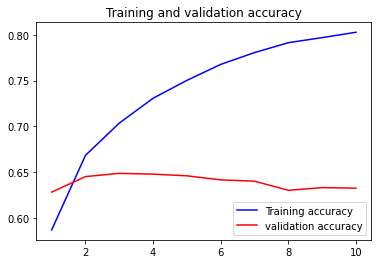

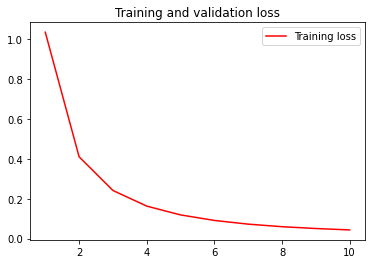

In [20]:
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    loss_epochs = []
    acc_epochs = []
    test_acc_epochs = []
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        process_bar = tqdm(train_iter)
        for (X, y) in process_bar:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 0.5)   # 梯度裁剪
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        loss_epochs.append(train_l_sum / batch_count)
        acc_epochs.append(train_acc_sum / n)
        test_acc_epochs.append(test_acc)
        # test_loss = compute_loss(test_iter, net, loss, device)
        print('epoch %d, train loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
    save_img(loss_epochs, acc_epochs, test_acc_epochs)


def compute_loss(data_iter, net, loss, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    loss_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            # net.eval() # 评估模式, 这会关闭dropout
            y_hat = net(X)
            loss_sum += loss(y_hat, y).cpu().item()
            # net.train() # 改回训练模式
            n += y.shape[0]
    return loss_sum / n


def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
    return acc_sum / n


def main():    
    vocab = get_vocab(x)
    vocab_dic = vocab.get_stoi()

    print('# words in vocab:', len(vocab))
    train_input_file = data_path + "/train_input3.npy"
    test_input_file = data_path + "/test_input3.npy"

    train_input = preprocess_data(train_sents, vocab_dic, train_input_file)
    test_input = preprocess_data(test_sents, vocab_dic, test_input_file)

    # train_input = get_sents_ids(train_input_file)
    train_set = TensorDataset(train_input, train_labels)
    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    # test_input = get_sents_ids(test_input_file)
    test_set = TensorDataset(test_input, test_labels)
    test_loader = DataLoader(test_set, batch_size)

    # 创建网络
    model = RNNClassifier(vocab, embed_size, num_hiddens, num_layers, 5)
    # 加载Glove词向量
    # model.embedding.weight.data.copy_(
        # load_pretrained_embedding(vocab.get_itos(), glove_vocab))
    # model.embedding.weight.requires_grad = True

    # 要过滤掉不计算梯度的embedding参数
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,
                                        model.parameters()), lr=lr)
    loss = nn.CrossEntropyLoss()
    train(train_loader, test_loader, model, loss, optimizer, device, num_epochs)

    # optimizer = 1
    # model = 2
    # train(model, optimizer, train_loader, batch_size, epochs)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)


if __name__ == "__main__":
    main()